The main goal of this model training is to predict whether a customer will respond to a marketing campaign based on their spending behavior and past engagement with promotions. It also aims to understand the most important factors influencing customer responses using SHAP feature importance analysis.

# Step 1: Import Required Libraries

* pandas, numpy → Handle tabular and numerical data.
* matplotlib.pyplot, seaborn → Used for visualization.
* shap → Explains feature importance using SHAP values.
* train_test_split → Splits data into training and testing sets.
* XGBClassifier → A powerful gradient boosting algorithm.
* accuracy_score, classification_report, confusion_matrix → Evaluate model performance.
* OneHotEncoder → Converts categorical features into a numerical format.
* StandardScaler → Standardizes numeric features to have zero mean and unit variance.
* SMOTE → Synthetic Minority Oversampling Technique for handling class imbalance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # For feature importance analysis
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Using XGBoost for better performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE  # Handling class imbalance

# Step 2: Load the Dataset

Reads the dataset from Google Sheets and stores it as a pandas DataFrame (df).

In [2]:
url = "https://docs.google.com/spreadsheets/d/1ew-NKCxOwbRhSY2lIeO-XnxIb5tZrNCilixxu6y8ZnM/export?format=csv"
df = pd.read_csv(url)

# Step 3: Handle Missing Values

Fills missing values in the Income column with the median value.

The median is chosen because it is less affected by outliers compared to the mean.

In [3]:
df["Income"].fillna(df["Income"].median(), inplace=True)

<ipython-input-3-2e8901f458b5>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Income"].fillna(df["Income"].median(), inplace=True)


# Step 4: Create a Total_Spending Feature

Sums up spending on different product categories to capture overall customer spending habits.

Helps in classifying customers into high-value vs. budget shoppers.

In [4]:
df["Total_Spending"] = (
    df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] +
    df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
)

# Step 5: Create a Marketing_Responsiveness Feature

Counts the total number of marketing campaigns a customer has accepted.

A higher score means the customer frequently interacts with promotions.

In [5]:
df["Marketing_Responsiveness"] = (
    df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] +
    df["AcceptedCmp4"] + df["AcceptedCmp5"] + df["Response"]
)

# Step 6: Categorize Customers into High-Value or Budget Shoppers

Classifies customers into two groups:
* High Value → Spending above the median.
* Budget → Spending below the median.

In [6]:
median_spending = df["Total_Spending"].median()
df["Shopper_Type"] = np.where(df["Total_Spending"] >= median_spending, "High Value", "Budget")

# Step 7: One-Hot Encoding for Categorical Variables

Converts categorical features into numeric format using one-hot encoding.

Drops the original categorical columns and replaces them with encoded versions.

In [7]:
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = encoder.fit_transform(df[["Education", "Marital_Status", "Shopper_Type"]])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

df = pd.concat([df.drop(columns=["Education", "Marital_Status", "Shopper_Type"]), encoded_df], axis=1)

# Step 8: Define Features (X) and Target (y)

Features (X) → All columns except ID, Response, and Dt_Customer (which are not useful for prediction).

Target (y) → The Response column, which indicates whether a customer responded to a marketing campaign.

In [8]:
X = df.drop(columns=["ID", "Response", "Dt_Customer"])
y = df["Response"]

# Step 9: Balance the Dataset Using SMOTE

SMOTE generates synthetic samples for the minority class (responders) to balance the dataset.

Prevents the model from being biased toward non-responders.



In [9]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 10: Split the Data into Training and Testing Sets

Splits data into 80% training and 20% testing sets.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


# Step 11: Standardize Numerical Features

Normalizes numerical values to ensure fair comparisons between different features.

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 12: Train the XGBoost Model

Trains XGBoost, a gradient boosting model designed for high performance.

In [12]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# Step 13: Make Predictions

Uses the trained model to predict customer responses.

In [13]:
y_pred_xgb = xgb_model.predict(X_test)


# Step 14: Evaluate the Model

Computes accuracy, precision, recall, and F1-score.

In [14]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)


Step 15: Visualize Confusion Matrix

Displays a confusion matrix as a bar chart instead of a heatmap.

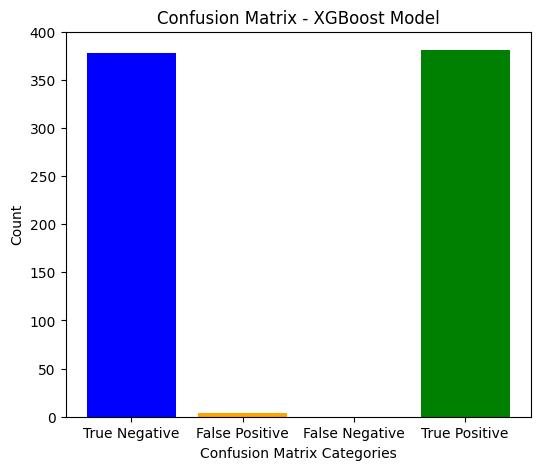

In [15]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 5))
plt.bar(["True Negative", "False Positive", "False Negative", "True Positive"], cm_xgb.flatten(), color=["blue", "orange", "red", "green"])
plt.xlabel("Confusion Matrix Categories")
plt.ylabel("Count")
plt.title("Confusion Matrix - XGBoost Model")
plt.show()

# Step 16: Feature Importance Analysis Using SHAP

Uses SHAP values to explain feature importance.

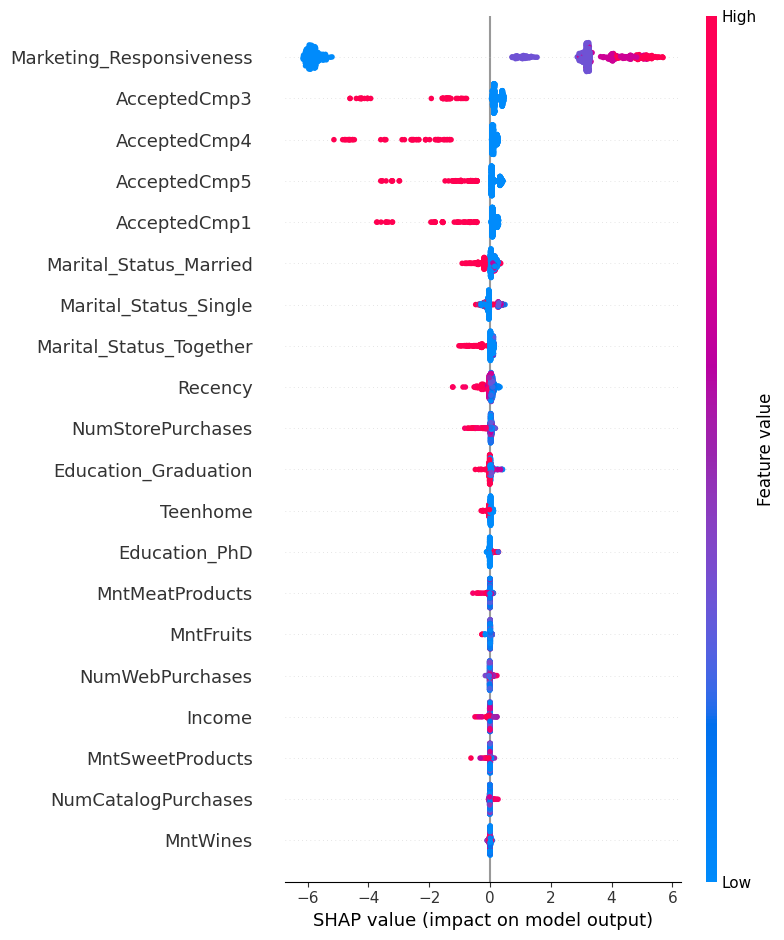

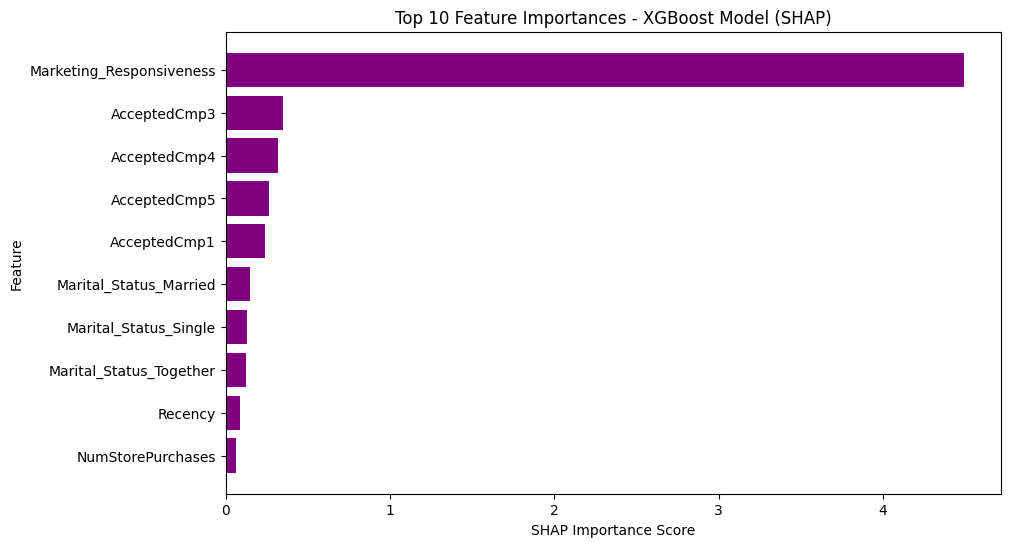

In [16]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot.
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# SHAP Bar Plot for Top 10 Most Important Features.
shap_values_mean = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.Series(shap_values_mean, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(shap_importance.index[:10], shap_importance.values[:10], color="purple")
plt.xlabel("SHAP Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances - XGBoost Model (SHAP)")
plt.gca().invert_yaxis()
plt.show()


# Retrospective: The Below is the Entire Code

<ipython-input-17-a0914bd18a48>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Income"].fillna(df["Income"].median(), inplace=True)


----- Results: XGBoost Model ------------------------------------------
XGBoost Model Accuracy: 0.9948

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       382
           1       0.99      1.00      0.99       381

    accuracy                           0.99       763
   macro avg       0.99      0.99      0.99       763
weighted avg       0.99      0.99      0.99       763



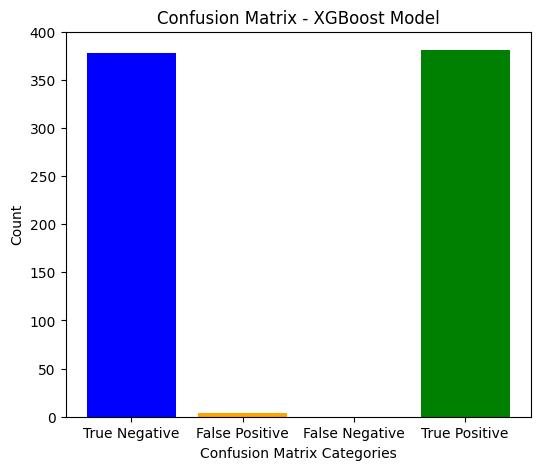

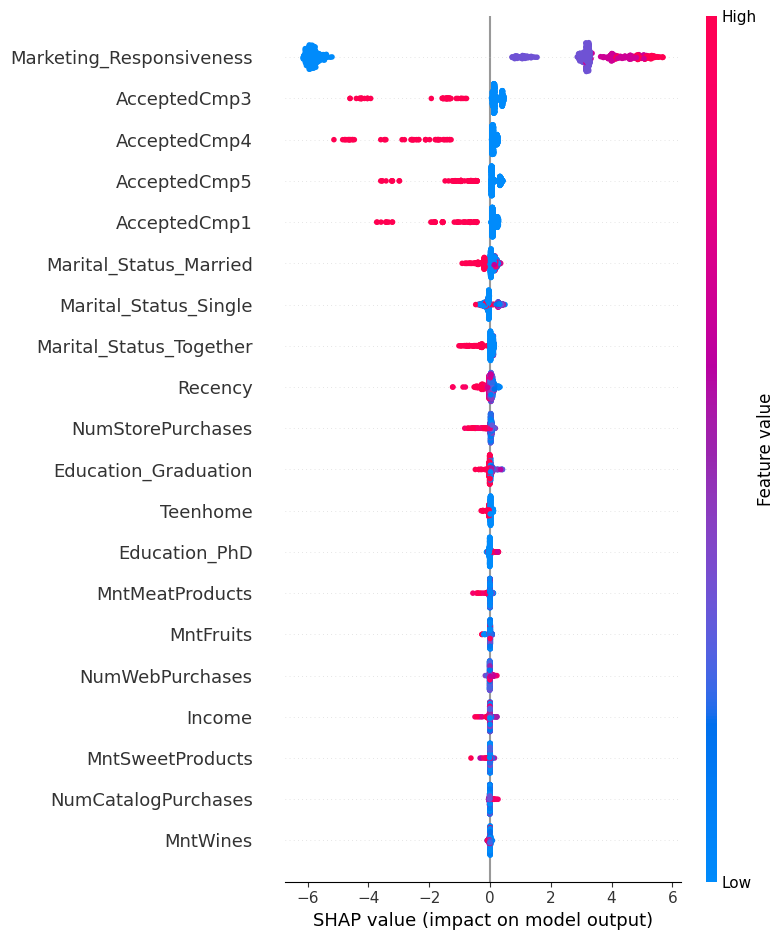

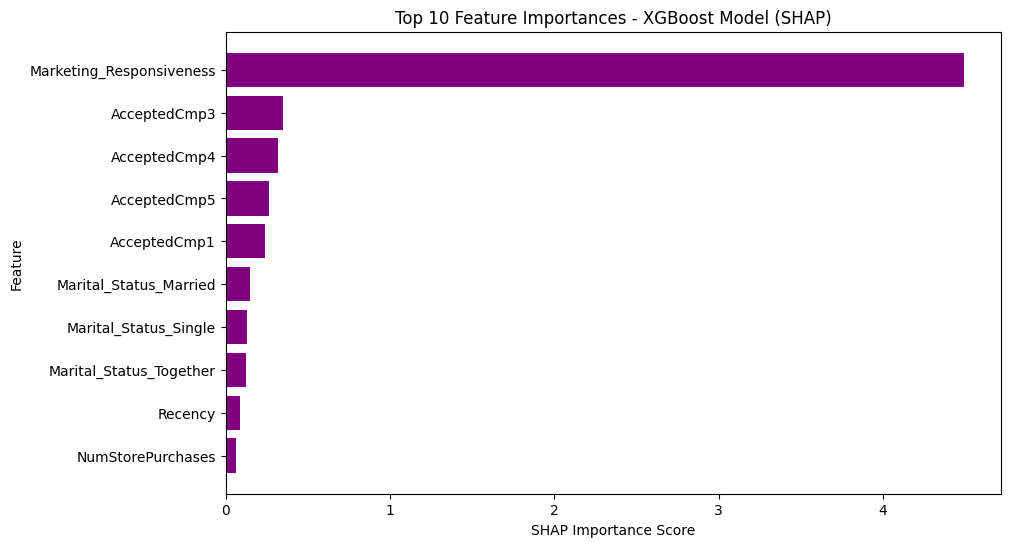

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # For feature importance analysis
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Using XGBoost for better performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE  # Handling class imbalance

# Load dataset (Google Sheets link).
url = "https://docs.google.com/spreadsheets/d/1ew-NKCxOwbRhSY2lIeO-XnxIb5tZrNCilixxu6y8ZnM/export?format=csv"
df = pd.read_csv(url)

# Fill missing values in 'Income' column with median.
df["Income"].fillna(df["Income"].median(), inplace=True)

# Create "Total_Spending" feature.
df["Total_Spending"] = (
    df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] +
    df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
)

# Create "Marketing_Responsiveness" feature.
df["Marketing_Responsiveness"] = (
    df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] +
    df["AcceptedCmp4"] + df["AcceptedCmp5"] + df["Response"]
)

# Categorize customers into High-Value or Budget shoppers.
median_spending = df["Total_Spending"].median()
df["Shopper_Type"] = np.where(df["Total_Spending"] >= median_spending, "High Value", "Budget")

# One-Hot Encoding for categorical features ('Education', 'Marital_Status', 'Shopper_Type').
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = encoder.fit_transform(df[["Education", "Marital_Status", "Shopper_Type"]])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

# Merge encoded features into dataframe & drop original categorical columns.
df = pd.concat([df.drop(columns=["Education", "Marital_Status", "Shopper_Type"]), encoded_df], axis=1)

# Define Features (X) and Target (y).
X = df.drop(columns=["ID", "Response", "Dt_Customer"])
y = df["Response"]

# Balance dataset using SMOTE.
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Normalize numerical features using StandardScaler.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train XGBoost Model.
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions.
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model.
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)

# Display Results.
print("----- Results: XGBoost Model ------------------------------------------")
print(f"XGBoost Model Accuracy: {accuracy_xgb:.4f}")
print("\nClassification Report:\n", classification_report_xgb)

# Compute confusion matrix for XGBoost Model.
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot Confusion Matrix using a Histogram instead of Heatmap.
plt.figure(figsize=(6, 5))
plt.bar(["True Negative", "False Positive", "False Negative", "True Positive"], cm_xgb.flatten(), color=["blue", "orange", "red", "green"])
plt.xlabel("Confusion Matrix Categories")
plt.ylabel("Count")
plt.title("Confusion Matrix - XGBoost Model")
plt.show()

# Feature Importance using SHAP values.
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot.
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# SHAP Bar Plot for Top 10 Most Important Features.
shap_values_mean = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.Series(shap_values_mean, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(shap_importance.index[:10], shap_importance.values[:10], color="purple")
plt.xlabel("SHAP Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances - XGBoost Model (SHAP)")
plt.gca().invert_yaxis()
plt.show()
